In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tqdm import tqdm

import matplotlib.pyplot as plt



In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

In [3]:
Transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(IMAGE_SIZE),
     transforms.Normalize((0.5),(0.5))])

train_dataset = datasets.MNIST(root="C:/Users/Arun/pytorch/datasxts", train=True, download=True, transform=Transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


In [4]:
dataiter = iter(train_dataset)
images, labels = next(dataiter)  
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(0.9843)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=20) -> None:
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(                                                       #[B x C x H x W]
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),   #[64 x 8 x 16 x 16]
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),  #[64 x 16 x 8 x 8]
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), #[64 x 32 x 4 x 4]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), #[64 x 64 x 2 x 2]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), #[64 x 128 x 1 x 1]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

        )
        
        self.mean = nn.Linear(128*1, latent_dim) # 4 because the no of pixels in the last spatial dimension is 4
        self.var = nn.Linear(128*1, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, 128*1)
         
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1), #[B x 64 x 2 x 2]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1), #[B x 32 x 4 x 4]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), #[B x 16 x 8 x 8]
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1), #[B x 8 x 16 x 16]
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), #[B x 1 x 32 x 32]
            nn.Tanh()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = torch.flatten(encoded, start_dim=1)
        
        mean = self.mean(encoded)
        var = self.var(encoded)
        
        # REPARAMETERIZATION TRICK
        std = torch.exp(0.5*var)
        eps = torch.randn_like(std)
        latent = mean + (eps * std) 
        
        decoder_input = self.decoder_input(latent)
        # print("size", decoder_input.shape)
        decoder_input = decoder_input.view(-1, 128, 1, 1)
        # print("size", decoder_input.shape)
        recons = self.decoder(decoder_input)
        
        return recons, mean, var
    
    def loss_function(self, recon_x, x, mu, log_var):
        
        recon_loss = 0.5 * F.mse_loss(recon_x, x, reduction="sum")
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=-1)

        return (recon_loss + KLD).mean(), recon_loss.mean(), KLD.mean()

# vae = VAE(latent_dim=20)
# input_tensor = torch.randn((64, 1, 32, 32))
# recons, mean, var = vae(input_tensor)
# loss, recon_loss, KLD = vae.loss_function(recons, input_tensor, mean, var)
# print(loss, recon_loss, KLD)


In [6]:
def train_vae(model, dataloader, epochs=10, lr=1e-3, device='cpu'):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []


    for epoch in range(epochs):
        epoch_loss = 0
        with tqdm(enumerate(dataloader, start=1), total=len(dataloader), unit="batch") as t:
            for batch_idx,batch in t:
                img, _ = batch
                img = img.to(device)
                
                optimizer.zero_grad()
                recons, mu, log_var = model(img)
                loss, recon_loss, KLD = model.loss_function(recons, img, mu, log_var)

                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
                t.set_description(f'Epoch [{epoch+1}/{epochs}]')
                t.set_postfix({'Training loss': f'{epoch_loss/batch_idx:.3f}', 'Batch loss': f'{loss:.3f}', 'Recon loss': f'{recon_loss:.3f}', 'KLD': f'{KLD:.3f}'})
            
            average_epoch_loss = epoch_loss / len(dataloader)
            loss_history.append(average_epoch_loss)
            # print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_epoch_loss:.4f}')
    
    return loss_history


In [7]:
# Test function
def test_vae(model, dataloader, num_images=10, device="cpu"):
    model.eval()
    inputs, outputs = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            img, _ = batch
            img = img.to(device)

            recons, _, _ = model(img)
            inputs.append(img.cpu())
            outputs.append(recons.cpu())
            if len(inputs) * img.size(0) >= num_images:
                break
    
    inputs = torch.cat(inputs)[:num_images]
    outputs = torch.cat(outputs)[:num_images]
    
    return inputs, outputs

# Visualization function
def plot_reconstructions(inputs, outputs, num_images=10):
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images*2))
    
    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(inputs[i].squeeze(), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')
        
        # Reconstructed image
        axes[i, 1].imshow(outputs[i].squeeze(), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latent_dim = 2
vae = VAE(latent_dim=latent_dim).to(device)

# Train the model
epochs = 100
learning_rate = 1e-3
print('Number of params in Model: {}'.format(
    sum(p.data.nelement() for p in vae.parameters() if p.requires_grad),
))
loss_history = train_vae(vae, train_loader, epochs=epochs, lr=learning_rate, device=device)

# Plot the loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

# Test the VAE model
inputs, outputs = test_vae(vae, test_loader, num_images=10, device=device)

# Plot the original and reconstructed images
plot_reconstructions(inputs, outputs, num_images=10)


  0%|          | 0/938 [00:00<?, ?batch/s]c:\Users\Arun\anaconda3\envs\pytorch\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch [5/100]:  50%|████▉     | 467/938 [00:09<00:09, 49.61batch/s, Training loss=3987.917, Batch loss=4369.152, Recon loss=4354.150, KLD=15.001]


KeyboardInterrupt: 

In [ ]:
import numpy as np
def plot_latent_space(model, n=50, figsize=10):
    model.eval()
    
    # Range of values for the latent space
    grid_x = np.linspace(-6, 6, n)
    grid_y = np.linspace(-6, 6, n)[::-1]
    
    figure = np.zeros((32 * n, 32 * n))
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            z_sample = torch.tensor(z_sample, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                x_decoded = model.decoder(model.decoder_input(z_sample).view(-1, 64, 2, 2)).cpu().numpy()
                
            digit = x_decoded[0].reshape(32, 32)
            figure[i * 32: (i + 1) * 32,
                   j * 32: (j + 1) * 32] = digit
    
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='gnuplot2')
    plt.show()

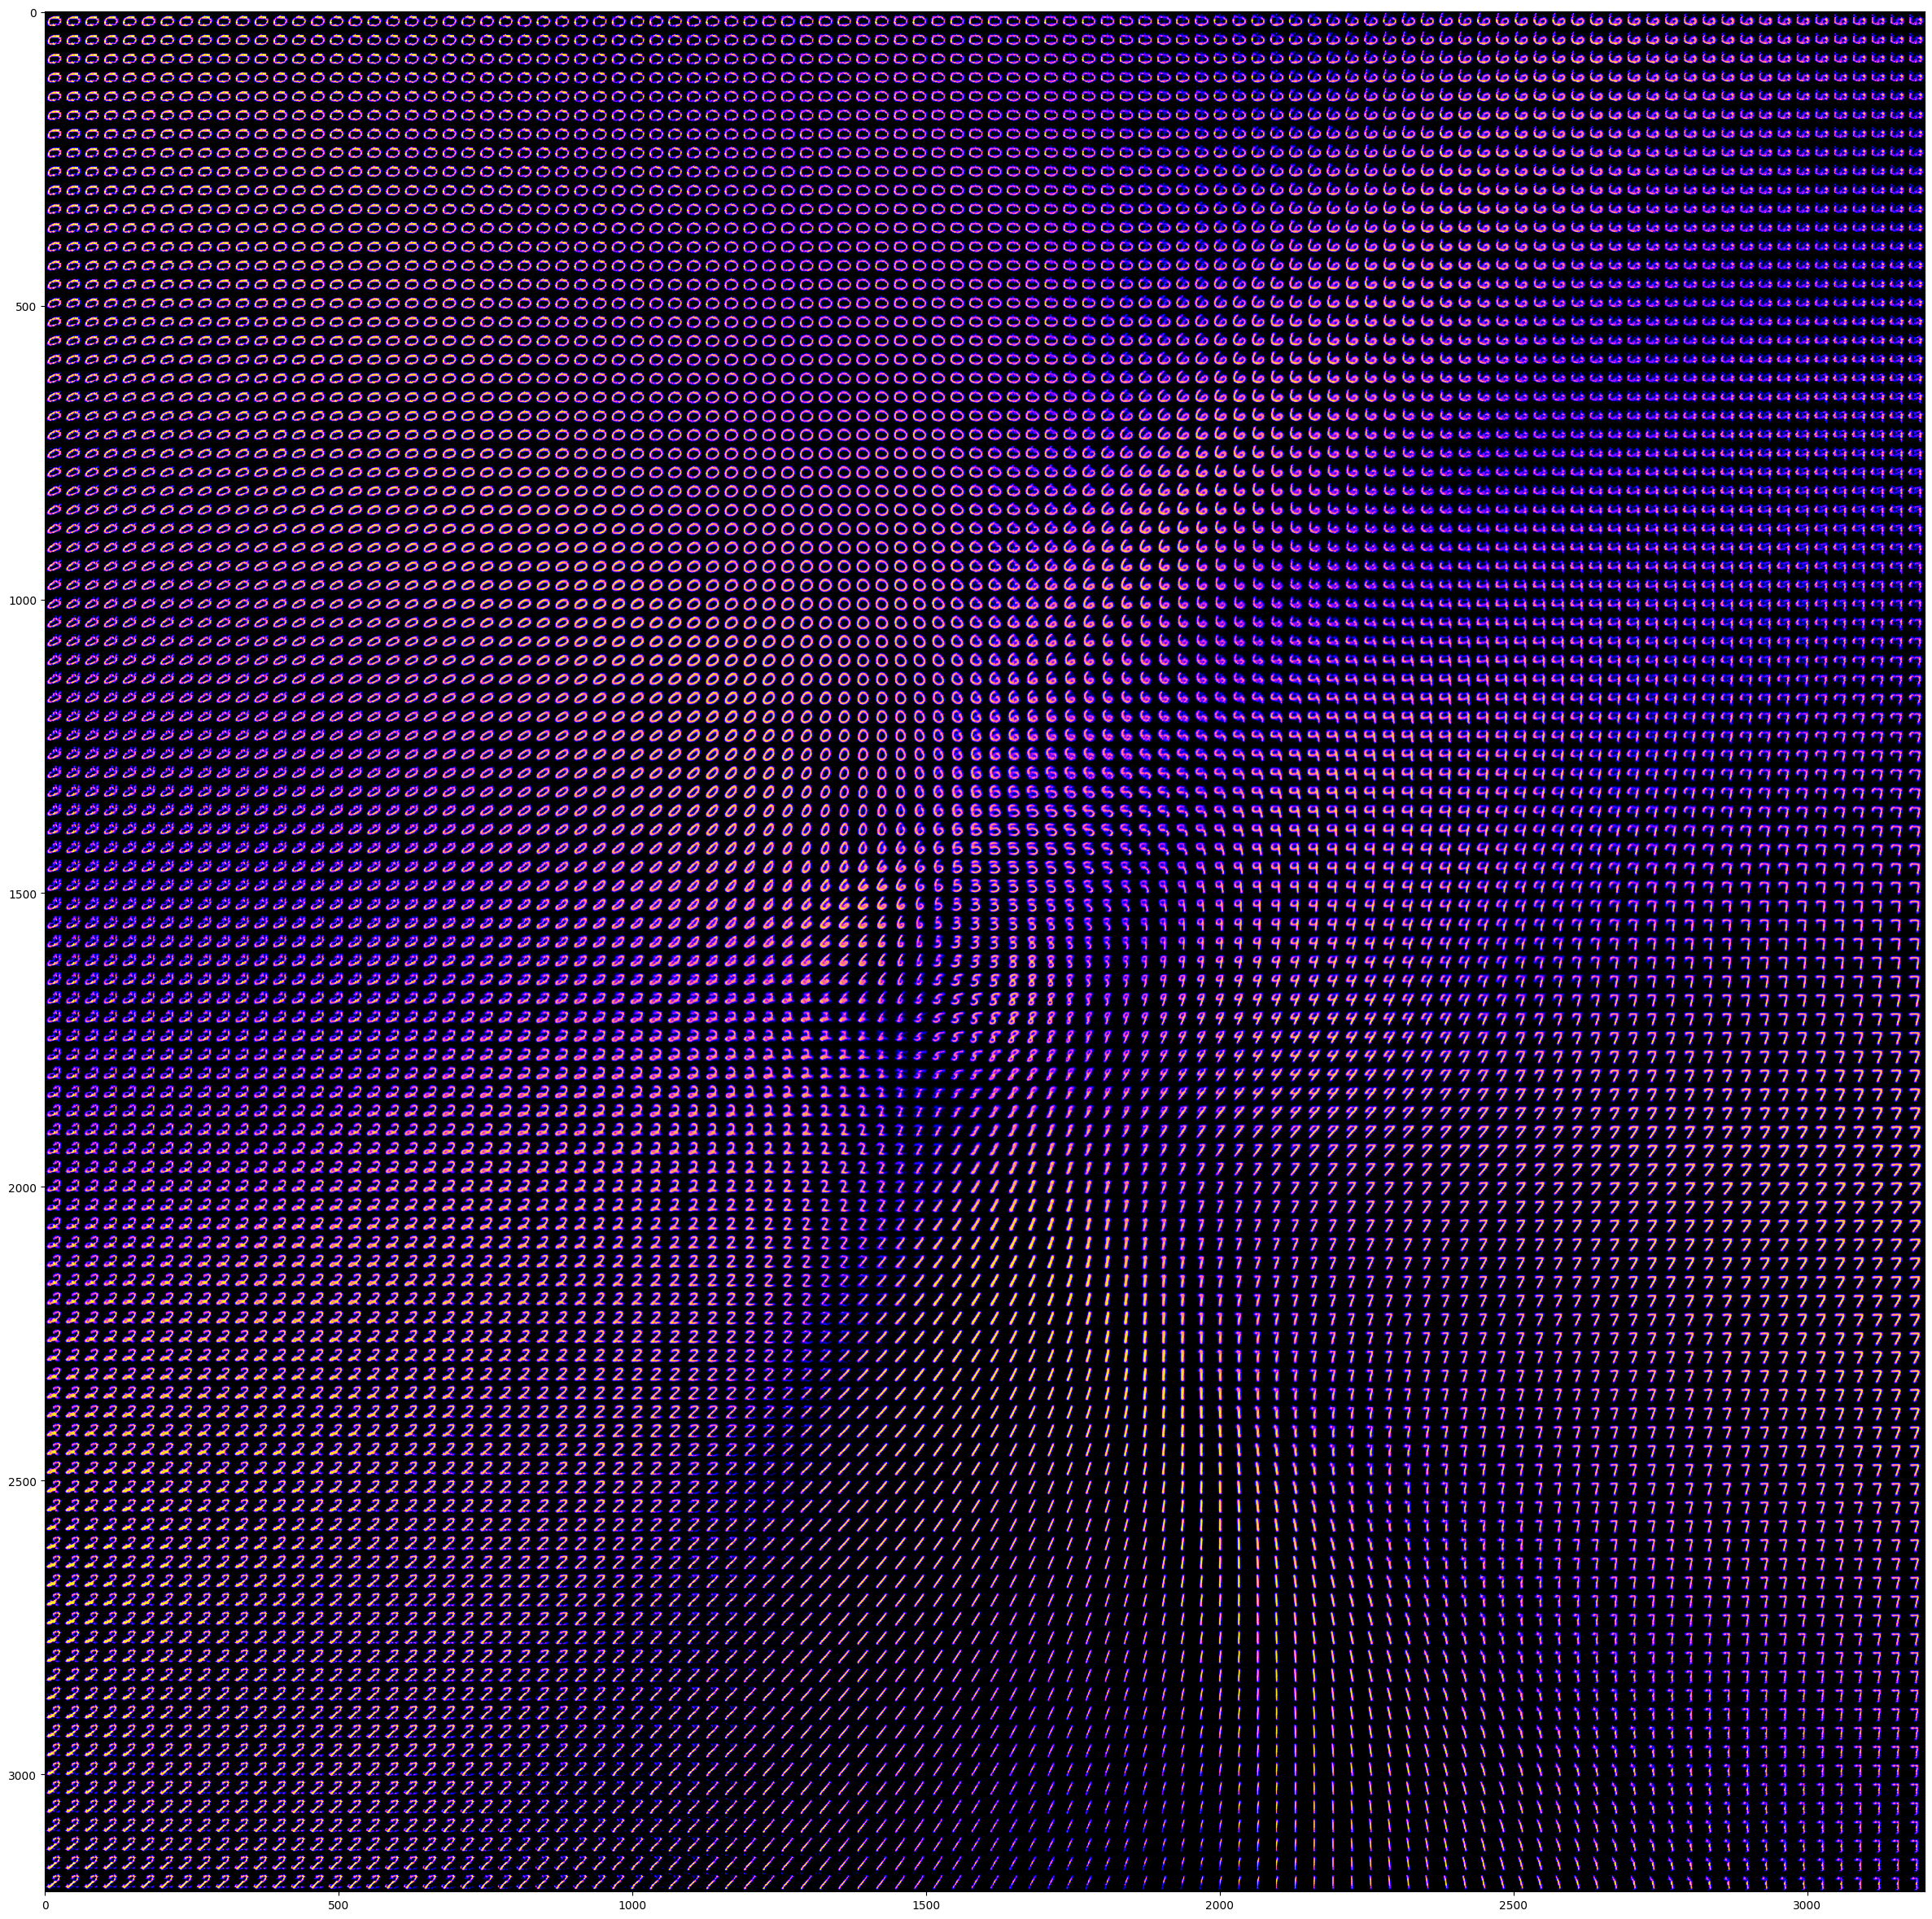

In [ ]:
plot_latent_space(vae, n=100, figsize=30)

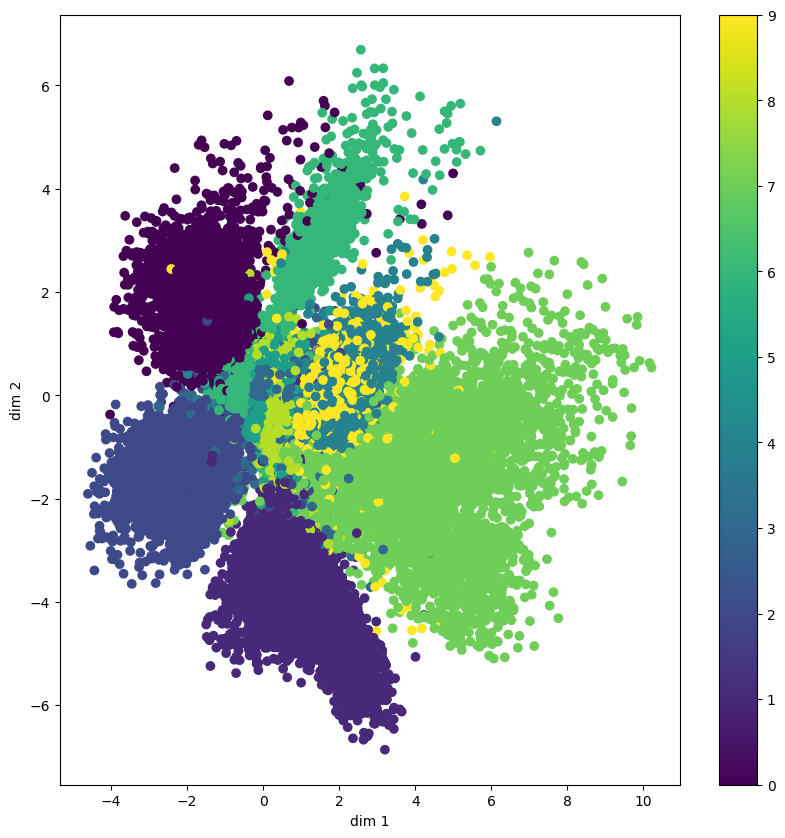

In [ ]:
def plot_latent_representations(model, dataloader):
    model.eval()
    all_mu = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            encoded = model.encoder(data)
            encoded = torch.flatten(encoded, start_dim=1)
            
            mean = model.mean(encoded)
            # var = model.var(encoded)
            # mu, _ = model.encode(data)
            all_mu.append(mean.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='viridis')
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.colorbar(scatter)
    plt.show()

# Example usage
plot_latent_representations(vae, test_loader)